# Learner

This notebook contains the source code for the Learner module in the MiniAI framework.

In [ ]:
#| default_exp learner

In [ ]:
#| export
import math, torch, matplotlib.pyplot as plt, numpy as np
from operator import itemgetter
import fastcore.all as fc

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F

from datasets import load_dataset, load_dataset_builder
from tqdm.auto import tqdm

import torchvision.transforms.functional as TF
from fastcore.test import test_close
from contextlib import contextmanager
from functools import partial

from operator import attrgetter,itemgetter
from torcheval.metrics import *

import pandas as pd
from miniai.conv import *
from nbdev.showdoc import *

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

<torch._C.Generator>

In [ ]:
name = 'fashion_mnist'
dsd = load_dataset(name)
dsd

/Users/olly/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Found cached dataset fashion_mnist (/Users/olly/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
def transforms(b):
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b

In [ ]:
tds = dsd.with_transform(transforms)

In [ ]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f 

In [ ]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds) if as_tuple else default_collate) for ds in dd.values()])

In [ ]:
dls = DataLoaders.from_dd(tds, batch_size=256)
b = next(iter(dls.train))
xb, yb = b
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

## Convnet

In [ ]:
def get_model():
    return nn.Sequential(
        ConvNormAct(1, 4),                 #14x14
        ConvNormAct(4, 8),                 #7x7
        ConvNormAct(8, 16),                #4x4
        ConvNormAct(16, 32),               #2x2
        ConvNormAct(32, 64),               #1x1
        nn.Flatten(),
        nn.Linear(64, 10),
    )

In [ ]:
next(iter(dls.train))[0].shape

torch.Size([256, 1, 28, 28])

## Exceptions

In [ ]:
#| export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass
class CancelFull_EpochException(Exception): pass

## Learner class

In [ ]:
#| export
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
#| export
class Learner:
    def __init__(self, dls, model, opt_func=optim.SGD, loss_func=F.cross_entropy, cbs=None):
        fc.store_attr()
        if cbs is not None:
            for cb in cbs: cb.learn = self
        
    @contextmanager
    def callback_context(self, name):
        try:
            self.callback(f"before_{name}")
            yield
            self.callback(f"after_{name}")
        except globals()[f'Cancel{name.title()}Exception']: pass
        
    def fit(self, lr, epochs, one_cycle=False):
        self.lr, self.n_epochs, self.epochs, self.one_cycle  = lr, epochs, range(epochs), one_cycle
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.callback_context('fit'):
            for self.epoch in self.epochs:
                with self.callback_context('full_epoch'):
                    self._one_epoch(train=True)
                    self._one_epoch(train=False)
        
    def _one_epoch(self, train):
        self.model.training = train
        if train: self.dl = self.dls.train
        else: self.dl = self.dls.valid
        if self.one_cycle: self.scheduler = OneCycleLR(self.opt, max_lr=self.lr*1.3, total_steps=len(self.dl))
        with self.callback_context('epoch'):
            for self.batch in self.dl:
                with self.callback_context('batch'):
                    self._one_batch()
        
    def _one_batch(self):
        self.xb, self.yb = self.batch
        self.predict()
        self.get_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.scheduler_step()
            self.mom_grad()
            
    def callback(self, name): 
        if self.cbs is not None:
            for cb in sorted(self.cbs, key=attrgetter('order')): 
                method = getattr(cb, name, None)
                if method is not None: method()

## Callbacks

In [ ]:
#| export
class Callback(): order = 0

### Metrics

In [ ]:
#| export
def to_cpu(b):
    if isinstance(b, list): return [to_cpu(o) for o in b]
    if isinstance(b, tuple): return tuple(to_cpu(list(b)))
    return b.detach().cpu()

In [ ]:
#| export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = metrics
        self.all_metrics['loss'] = Mean()
        
    def _log(self): 
        print(self.log)
    
    def before_fit(self): self.learn.metrics = self
    def before_full_epoch(self):
        self.log = pd.DataFrame({
            "Train loss": 0,
            "Valid loss": 0,
            "Accuracy": 0
        }, index=range(self.learn.epoch, self.learn.epoch+1))
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    def after_batch(self):
        x, y = to_cpu(self.learn.batch)
        self.metrics['accuracy'].update(to_cpu(self.learn.preds), y)
        self.metrics['loss'].update(to_cpu(self.learn.loss), weight=len(x))
    def after_epoch(self): 
        if self.learn.model.training: self.log['Train loss'] = round(float(self.all_metrics['loss'].compute().detach()), 4)
        if not self.learn.model.training: 
            self.log['Valid loss'] = round(float(self.all_metrics['loss'].compute().detach()), 4)
            self.log['Accuracy'] = round(float(self.all_metrics['accuracy'].compute().detach()), 4)
    def after_full_epoch(self):
        # log = {k:f"{v.compute():.3f}" for k, v in self.all_metrics.items()}
        self._log()

### Progress

In [ ]:
#| export
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): 
        self.plot = plot
        if plot: self.losses, self.counter = [], 0
        
    def before_fit(self): self.learn.epochs = tqdm(self.learn.epochs, total=self.learn.n_epochs)
    
    def before_epoch(self):
        self.learn.dl = tqdm(self.learn.dl, leave=False, total=len(self.learn.dl))
    def after_batch(self):
        if self.plot and self.learn.model.training:
            self.losses.append(float(self.learn.loss.detach()))
            self.counter += 1
    
    def after_fit(self):
        if self.plot:
            self._plot()
            
    def _plot(self):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.plot(range(self.counter), self.losses)
        ax.set_title('Change in loss')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Loss')

### Send to device

In [ ]:
#| export
def get_device():
    if torch.backends.mps.is_available(): device = 'mps' 
    if torch.cuda.is_available(): device = 'cuda'
    else: device = 'cpu'
    return device

In [ ]:
#| export
class DeviceCB(Callback):
    def __init__(self): self.device = get_device()
    def before_fit(self): self.learn.model.to(self.device)
    def before_batch(self): 
        xb, yb = self.learn.batch
        self.learn.batch = (xb.to(self.device), yb.to(self.device))

### Subclass

In [ ]:
#| export
class BaseLearner(Learner):
    def predict(self): self.preds = self.model(self.xb)
    def get_loss(self): self.loss = self.loss_func(self.preds, self.yb)
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def scheduler_step(self): 
        if self.one_cycle: self.scheduler.step()
    def mom_grad(self): self.opt.zero_grad()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
0      0.5272      0.4434    0.8381


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
1      0.3565      0.3776    0.8612


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
2      0.3199      0.3588    0.8685


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
3      0.2982       0.345    0.8755


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
4      0.2829      0.3428    0.8753


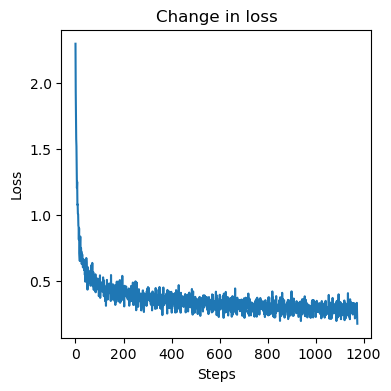

In [ ]:
cbs = [MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB()]
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.2, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
0      0.5619      0.3776    0.8595


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
1      0.3509      0.3393    0.8742


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
2      0.3186      0.3255    0.8781


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
3      0.3005       0.318    0.8825


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
4       0.287      0.3137    0.8825


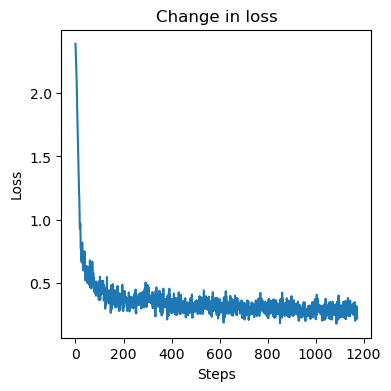

In [ ]:
cbs = [MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB()]
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.2, 5, one_cycle=True)

## Momentum

In [ ]:
#| export
class MomentumLearner(Learner):
    def __init__(self, dls, model, opt_func=optim.SGD, loss_func=F.cross_entropy, cbs=None, mom=0.85):
        self.mom = mom
        super().__init__(dls, model, opt_func, loss_func, cbs)
    def predict(self): self.preds = self.model(self.xb)
    def get_loss(self): self.loss = self.loss_func(self.preds, self.yb)
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def scheduler_step(self): 
        if self.one_cycle: self.scheduler.step()
    def mom_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
0      4.3358      4.2293    0.2886


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
1      6.5622      4.3474     0.193


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
2      6.9421      4.0746    0.1953


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
3      6.5169      4.6329    0.1888


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

   Train loss  Valid loss  Accuracy
4       6.734      3.8762    0.1918


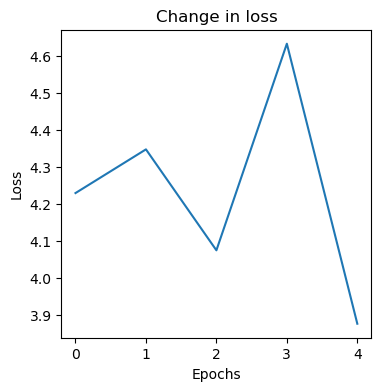

In [ ]:
cbs = [MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB()]
model = get_model()
learn = MomentumLearner(dls, model, cbs=cbs)
learn.fit(0.2, 5, one_cycle=True)

## LR Finder

In [ ]:
#| export
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
#| export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3): self.gamma = gamma
    def before_fit(self): 
        self.lrs, self.losses = [], []
        self.min = math.inf
        self.sched = ExponentialLR(self.learn.opt, self.gamma)
        
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: 
            plt.plot(self.lrs, self.losses)
            plt.xscale('log')
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss')
            raise CancelFitException()
        self.sched.step()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

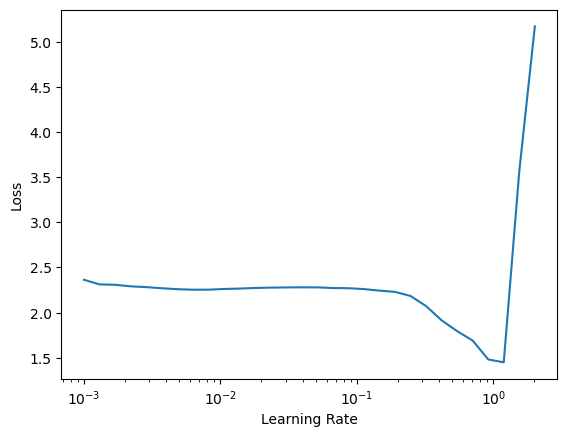

In [ ]:
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), LRFinderCB()]
model = get_model()
learn = MomentumLearner(dls, model, cbs=cbs)
learn.fit(0.001, 1)

In [ ]:
import miniai

In [ ]:
miniai

<module 'miniai' from '/Users/olly/Documents/Data_science/fastai_2/miniai/miniai/__init__.py'>

In [ ]:
from miniai.conv import *

In [ ]:
miniai.conv

<module 'miniai.conv' from '/Users/olly/Documents/Data_science/fastai_2/miniai/miniai/conv.py'>

## Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()